In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
# Set scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=120, facecolor='white')

In [88]:
ls_file = os.listdir("../data/processed")
ls_file

['7305_D0_filtered.h5ad',
 '7305_D5__UNTR_filtered.h5ad',
 '7305_D9_OLAP_filtered.h5ad',
 'umap_clusters_7305_D0_v1.csv',
 '7305_D9_UNTR_filtered.h5ad']

7305_D9_UNTR
Cells: 144458, Genes: 42363
filtered out 96138 cells that have less than 100 genes expressed
filtered out 1623 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
already processed


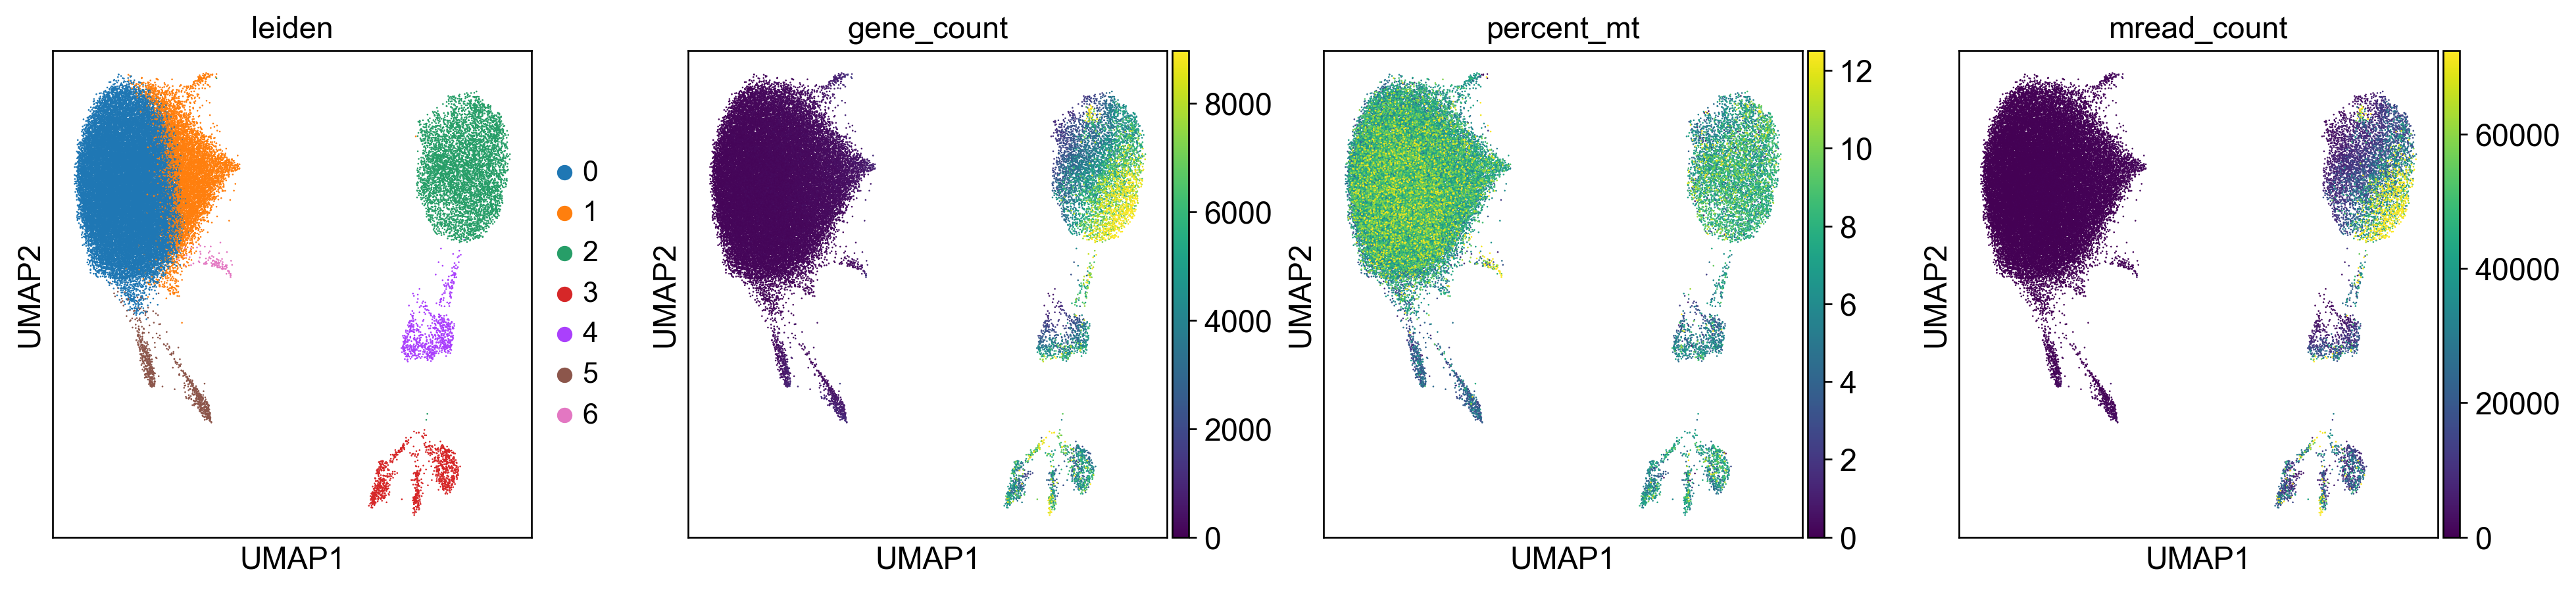

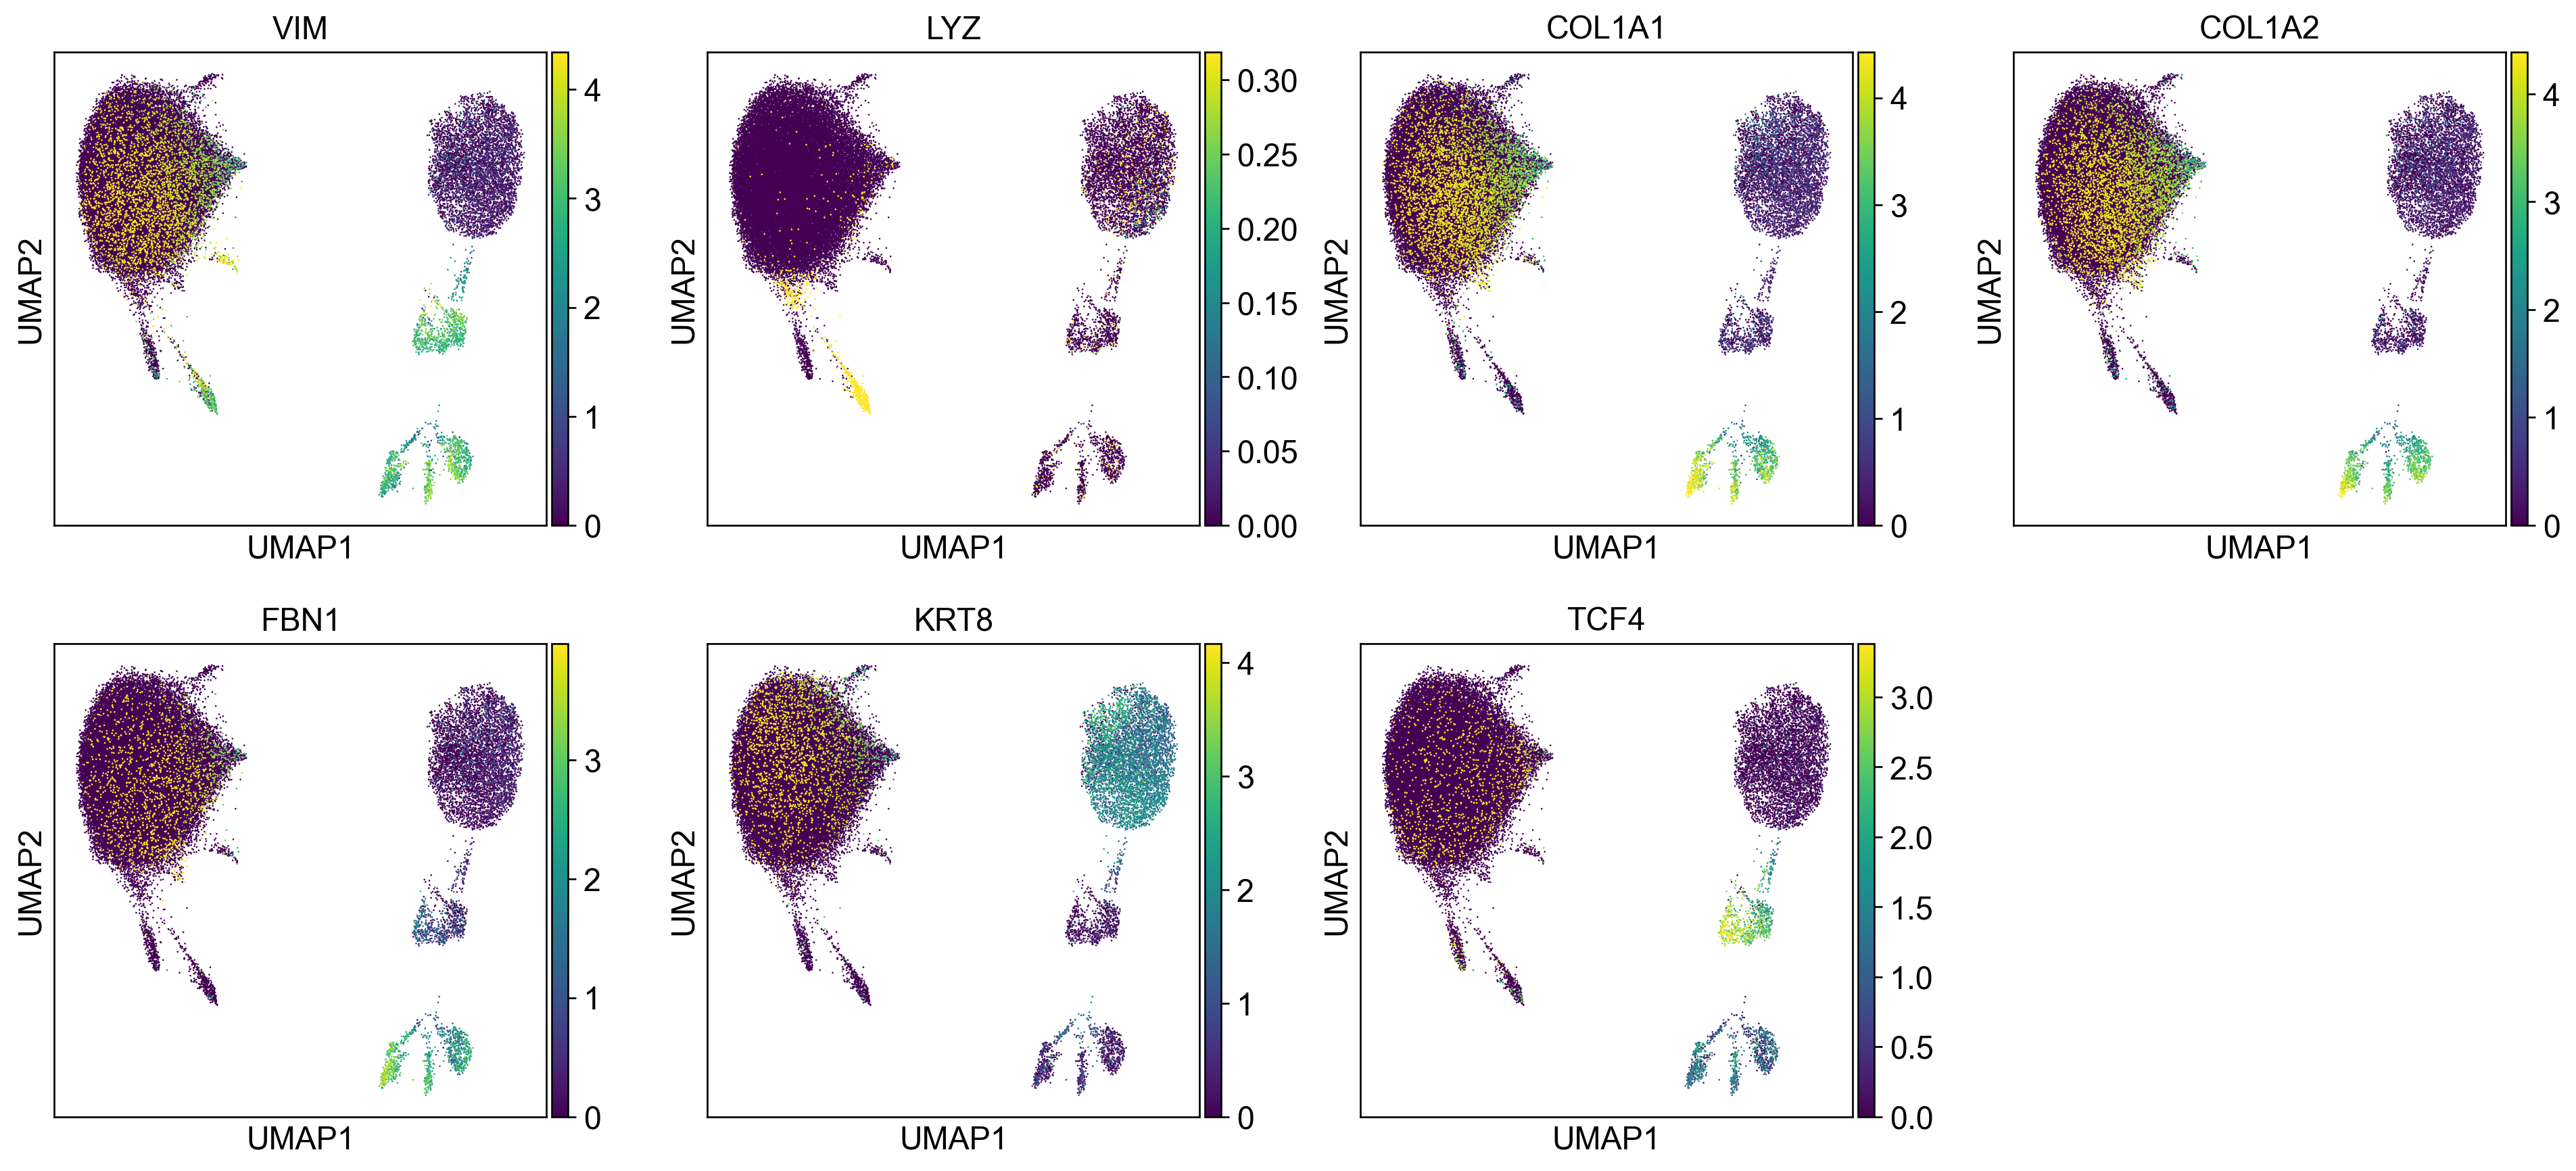

In [100]:
# Load your Day 0 data to verify
for s_file in ls_file:
    if s_file.find('filtered.h5ad')>-1:
        print(s_sample)
        s_sample = s_file.split("_filtered")[0]
        adata = sc.read_h5ad(f"../data/processed/{s_file}")
        # VERIFY METADATA
        print(f"Cells: {adata.n_obs}, Genes: {adata.n_vars}")
        adata.obs['OPTR'] = int(s_file.split('_')[0])
        adata.obs['day'] = int(s_file.split('_')[1].replace("D",""))
        adata.obs['treatment'] = s_file.split('_filtered')[0].split('_')[-1]
        sc.pp.filter_cells(adata, min_genes=100)
        sc.pp.filter_genes(adata, min_cells=3)
        # Save raw counts in a 'layer' before we transform the data
        adata.layers["counts"] = adata.X.copy()
        # Log-normalize
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        # Identify Highly Variable Genes (the genes that actually drive differences)
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
        # Filter the object to only highly variable genes to speed up PCA
        adata = adata[:, adata.var.highly_variable].copy()
        if os.path.exists(f"../data/processed/umap_clusters_{s_sample}_v1.csv"):
            print("already processed")
            saved_results = pd.read_csv(f"../data/processed/umap_clusters_{s_sample}_v1.csv",index_col=0) 
            # Re-attach to the object
            adata.obs['leiden'] = saved_results['leiden'].astype('category')
            adata.obsm['X_umap'] = saved_results[['UMAP1', 'UMAP2']].values
        else:

            # Scaling and PCA
            sc.pp.scale(adata, max_value=10)
            sc.tl.pca(adata, svd_solver='arpack')
            # Build the neighborhood graph
            sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
            # Compute UMAP
            sc.tl.umap(adata)
            # Leiden clustering (standard for single-cell)
            sc.tl.leiden(adata, resolution=0.5)

                        # -- EXPORT DATA ---
            # Extract UMAP coordinates and cluster labels
            metadata_to_save = adata.obs[['leiden', 'OPTR', 'treatment','n_genes']].copy()
            umap_coords = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'], index=adata.obs_names)
            
            # Combine and save as a small file
            combined_results = pd.concat([metadata_to_save, umap_coords], axis=1)
            combined_results.to_csv(f"../data/processed/umap_clusters_{s_sample}_v1.csv") 
        # Plot UMAP colored by Cluster and by your Parse Sub-pools
        sc.pl.umap(adata, color=['leiden', 'gene_count','percent_mt','mread_count'],vmax='p99',vmin=0,ncols=4,
          save=f'qc_metrics_{s_sample}.png')
        color=['LSP1', 'PTPRC', 'CD4','CD68', 'FCGR3A','CD14', 'FCN1','CD1C', #immune FCN1:neutrophils'CD1C':dendritic,
               'EPCAM','KRT8','LYZ',#acinar
               'PECAM1','VWF','CDH5','TCF4',#TCF4 dendritic and endothelial
               'VIM','ACTA2','COL1A1','COL1A2','FBN1',#fibrillin1 Fibro-adipogenic progenitors
             ]
        color = adata.var.index[adata.var.index.isin(color)]
        # Look for your Immune Cells (Example: PTPRC is CD45)
        sc.pl.umap(adata, color=color, gene_symbols='gene_names',vmax='p98',vmin=0,ncols=4,
                  save=f'marker_genes_{s_sample}.png')
        break
        # 1. Rank the genes (default is Wilcoxon)
        # We use 'log1p' data usually stored in .X
        sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
        # 2. Visualize the top 10 genes for each cluster
        sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False,save=f'rank_genes_{s_sample}.png')
        # 3. Create a clean Table of the results
        result_table = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
        # Select the top 2 genes from each cluster automatically
        top_genes = [gene for sublist in result_table.values.tolist() for gene in sublist[:2]]
        # Remove duplicates while preserving order
        top_genes = list(dict.fromkeys(top_genes))
        # Plot
        sc.pl.dotplot(adata, var_names=top_genes, groupby='leiden', standard_scale='var',save=f'dotplot_{s_sample}.png')
        # Look for your Immune Cells (Example: PTPRC is CD45)
        sc.pl.umap(adata, color=top_genes, gene_symbols='gene_names',vmax='p98',vmin=0,ncols=4,
                  save=f'top_genes_{s_sample}.png')
        break